### Random forest regressor
* Regression problem
* Decision tree and regression tree
* Random forest regressor
* Random forest regressor with lag data

#### Regression problem
f : R^n -> R^m <br>
where n is the numbers of the input dimension and m is the numbers of the output dimension.

energy = f(temperature, humidity, rain, cloud, visibility, time_rs) <br>
n = 6, m = 1

#### Decision tree
https://www.youtube.com/watch?v=7VeUPuFGJHk

#### Regression tree
https://www.youtube.com/watch?v=g9c66TUylZ4

#### Random forest
https://www.youtube.com/watch?v=J4Wdy0Wc_xQ

Instead of considering all data, a random forest randomly picks subsets of the data. They are called "bootstrapping data". Each subset is used to train for a decision tree.

In [10]:
# Import basic modules
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

%matplotlib inline 

def read_owm_data(fn):
    data = pd.read_csv(fn)
    data = data.rename(columns=lambda x: x.strip())  
    
    dates = (data['timestamp']//1000).apply(lambda x: datetime.fromtimestamp(x))
    data.insert(loc=0, column='Dates', value=dates)
    data = data.set_index('Dates')
    data = data.rename(columns={"pwr": "SDGE"})

    time_rs = (data['timestamp'] - data['sunrise']) / (data['sunset'] - data['sunrise'])
    data.insert(loc=len(data.columns)-1, column='time_rs', value=time_rs)

    sdge = data.drop(['timestamp','sunrise','sunset'], axis=1) 
    sdge_lin = pd.get_dummies(sdge)
    
    return sdge_lin, ['temp', 'humidity', 'rain', 'cloud', 'visibility','time_rs']

def train_test(data, test_size = 0.15, test_num = -1, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # get the index after which test set starts
    if test_num == -1:
        test_index = int(len(df)*(1-test_size))
    else:
        test_index = len(df) - test_num
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    X_train = df.drop('SDGE', axis = 1).iloc[:test_index]
    y_train = df.SDGE.iloc[:test_index]
    X_test = df.drop('SDGE', axis = 1).iloc[test_index:]
    y_test = df.SDGE.iloc[test_index:]    
    
    return X_train, X_test, y_train, y_test

def train_test_rand(data, test_size = 0.15, scale = False, cols_to_transform=None):
    df = data.copy()
    
    # StandardScaler fit on the entire dataset
    if scale:
        scaler = StandardScaler()
        df[cols_to_transform] = scaler.fit_transform(df[cols_to_transform])
        
    data_X = df.drop('SDGE', axis = 1)
    data_Y = df.SDGE
    X_train0, X_test0, y_train0, y_test0 = train_test_split(data_X, data_Y, test_size=test_size, random_state=7)
    
    X_train = X_train0.copy(deep=True)
    X_test = X_test0.copy(deep=True)
    y_train = y_train0.copy(deep=True)
    y_test = y_test0.copy(deep=True)    
    
    return X_train, X_test, y_train, y_test

def error_metrics(y_pred, y_truth, model_name = None):
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)  

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)
    
    # Explained variance score: 1 is perfect prediction
    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )
    
    name_error = ['model', 'RMSE', 'MAE', 'R2']
    value_error = [model_name, RMSE, MAE, R2]
    list_error = list(zip(name_error, value_error))
    
    # Creating an empty dict to save all the erros from different models
    dict_error = dict()
    
    for error in list_error:
        dict_error[error[0]] = error[1]
        
    return(dict_error)

In [61]:
sdge_lin,cols_to_transform = read_owm_data('all_owm.csv')

print(sdge_lin.head())


X_train, X_test, y_train, y_test = train_test_rand(sdge_lin, test_size = 0.3, scale = False, cols_to_transform=cols_to_transform)

print(X_train.head())

                     temp  humidity  rain  cloud  visibility  time_rs  SDGE
Dates                                                                      
2020-02-18 00:00:00  22.0      56.0   0.0    0.0        90.0    -0.53   0.0
2020-02-18 01:00:00  21.0      56.0   0.0    0.0        90.0    -0.44   0.0
2020-02-18 02:00:00  20.0      60.0   0.0    0.0        80.0    -0.35   0.0
2020-02-18 03:00:00  19.0      63.0   0.0    0.0        80.0    -0.26   0.0
2020-02-18 04:00:00  19.0      63.0   0.0    0.0        80.0    -0.17   0.0
                      temp  humidity  rain  cloud  visibility  time_rs
Dates                                                                 
2020-02-20 14:00:00  33.33      35.0   0.0    0.0       100.0     0.55
2020-08-28 10:00:00  29.00      79.0   0.0   20.0       100.0     0.34
2020-03-14 09:00:00  31.04      62.0   0.0   30.0        60.0     0.28
2020-08-26 06:00:00  25.09      81.0   0.0   98.0       100.0    -0.09
2020-08-17 20:00:00  27.22      94.0   0.0

In [62]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [63]:
regr = RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_split=10, random_state=0)
regr.fit(X_train, y_train)

y_hat = regr.predict(X_train)
error_metrics(y_hat, y_train, 'Training data')

y_hat = regr.predict(X_test)
error_metrics(y_hat, y_test, 'Test data')


Error metrics for model Training data
RMSE or Root mean squared error: 14.08
Mean Absolute Error: 7.81
Variance score: 0.90

Error metrics for model Test data
RMSE or Root mean squared error: 15.16
Mean Absolute Error: 8.55
Variance score: 0.88


{'model': 'Test data',
 'RMSE': 15.155599890887773,
 'MAE': 8.547411921597314,
 'R2': 0.8755331691161515}

Text(0, 0.5, 'Predicted')

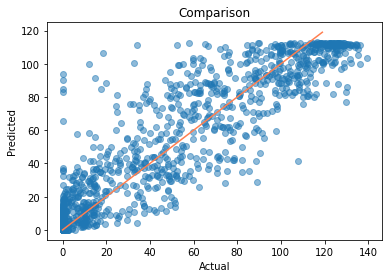

In [64]:
x = np.arange(120)
plt.plot(x,x,color='coral')

plt.scatter(y_test, y_hat, alpha=0.5)
plt.title('Comparison')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [69]:
_, X_week, _, y_week = train_test(sdge_lin, test_num = 7*24, scale = False, cols_to_transform=cols_to_transform)

y_week_hat = regr.predict(X_week)

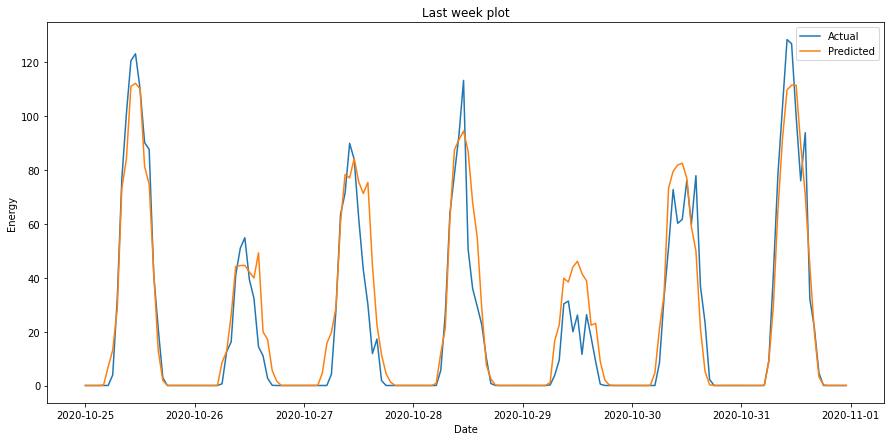

In [74]:
plt.figure(figsize = (15,7))
_ = plt.plot(X_week.index.values, y_week, label='Actual')
_ = plt.plot(X_week.index.values, y_week_hat, label='Predicted')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy')
_ = plt.legend()
_ = plt.title('Last week plot')

#### Random forest with lag data
We will take last day energy data into account.

In [113]:
lag_day = 2

# Creating the lag variables
for i in range(24):
    sdge_lin['lag'+str(i+1)] = sdge_lin['SDGE'].shift(lag_day * 24 + i + 1)
    
lag_sdge = sdge_lin.dropna()

print(lag_sdge.head())

X_train, X_test, y_train, y_test = train_test_rand(lag_sdge, test_size = 0.3, scale = False, cols_to_transform=cols_to_transform)

                     temp  humidity  rain  cloud  visibility  time_rs  SDGE  \
Dates                                                                         
2020-02-21 00:00:00  25.0      53.0   0.0    0.0        90.0    -0.55   0.0   
2020-02-21 01:00:00  24.0      57.0   0.0    0.0        90.0    -0.46   0.0   
2020-02-21 02:00:00  23.0      64.0   0.0    0.0        80.0    -0.37   0.0   
2020-02-21 03:00:00  22.0      64.0   0.0    0.0        80.0    -0.28   0.0   
2020-02-21 04:00:00  21.0      68.0   0.0    0.0        80.0    -0.19   0.0   

                     lag1  lag2  lag3  ...    lag15    lag16    lag17   lag18  \
Dates                                  ...                                      
2020-02-21 00:00:00   0.0   0.0   0.0  ...   63.720   36.716   14.408   0.888   
2020-02-21 01:00:00   0.0   0.0   0.0  ...   81.792   63.720   36.716  14.408   
2020-02-21 02:00:00   0.0   0.0   0.0  ...  119.584   81.792   63.720  36.716   
2020-02-21 03:00:00   0.0   0.0   0.0  ..

In [114]:
regr = RandomForestRegressor(n_estimators=100, max_depth=8, min_samples_split=10, random_state=0)
regr.fit(X_train, y_train)

y_hat = regr.predict(X_train)
error_metrics(y_hat, y_train, 'Training data')

y_hat = regr.predict(X_test)
error_metrics(y_hat, y_test, 'Test data')


Error metrics for model Training data
RMSE or Root mean squared error: 10.69
Mean Absolute Error: 5.37
Variance score: 0.94

Error metrics for model Test data
RMSE or Root mean squared error: 14.54
Mean Absolute Error: 7.21
Variance score: 0.89


{'model': 'Test data',
 'RMSE': 14.537851487677584,
 'MAE': 7.206892498583689,
 'R2': 0.8911717728595595}

Text(0, 0.5, 'Predicted')

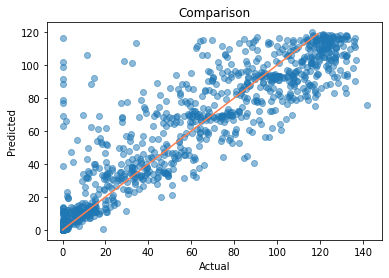

In [115]:
x = np.arange(120)
plt.plot(x,x,color='coral')

plt.scatter(y_test, y_hat, alpha=0.5)
plt.title('Comparison')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [116]:
_, X_week, _, y_week = train_test(lag_sdge, test_num = 7*24, scale = False, cols_to_transform=cols_to_transform)

y_week_hat = regr.predict(X_week)

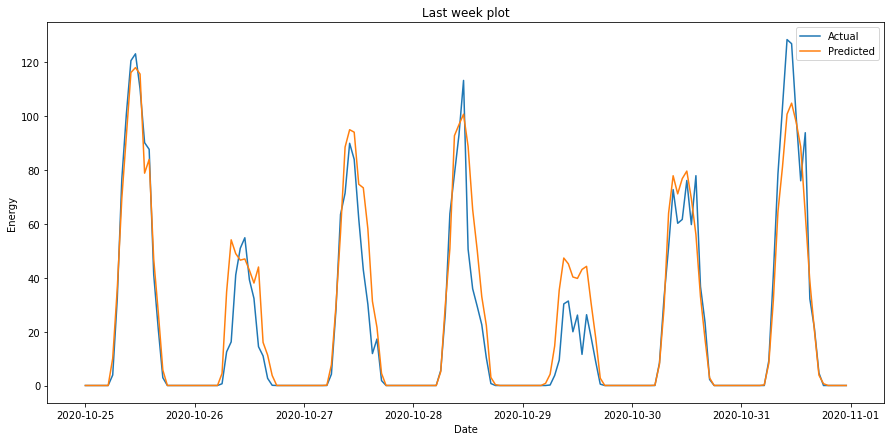

In [117]:
plt.figure(figsize = (15,7))
_ = plt.plot(X_week.index.values, y_week, label='Actual')
_ = plt.plot(X_week.index.values, y_week_hat, label='Predicted')

# set labels, legends and show plot
_ = plt.xlabel('Date')
_ = plt.ylabel('Energy')
_ = plt.legend()
_ = plt.title('Last week plot')